In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def set_plot_params(title, ylabel):
    plt.title(title)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks(rotation=30, fontsize=12)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30))


def calculate_ylim(data):
    ylim_min = min(data) - (max(data) - min(data)) * 0.1
    ylim_max = max(data) + (max(data) - min(data)) * 0.1
    return ylim_min, ylim_max


def draw_graph(data: pd.DataFrame, title: str, ylabel: str, date_lst: list, color="blue"):
    '''
    :param data: 시간 인덱스와 그래프로 표시할 정보가 있는 데이터프레임
    :param title: 그래프 제목
    :param ylabel: 그래프 y축 단위
    :param date_lst: 아웃라이어 날짜인덱스 리스트
    :param color: 그래프 색깔
    :return: 
    '''
    plt.figure(figsize=(18, 3), dpi=400)
    plt.plot(data.index, data.values, color=color, linestyle='--')
    for date in date_lst:
        plt.axvline(pd.to_datetime(date), color='red', linewidth=0.8, linestyle='--', label='Highlight Date')
    set_plot_params(title, ylabel)
    ylim_min, ylim_max = calculate_ylim(list(data.values))
    plt.ylim(ylim_min, ylim_max)
    plt.show()

In [3]:
def compute_CUSUM(X):
    CUSUM = np.cumsum(X ** 2)
    return CUSUM


def compute_gamma(X, T, m):
    mean_X = np.mean(X)
    r = X - mean_X  # 잔차 계산
    r_squared = r ** 2
    sigma_squared = np.mean(r_squared)

    gamma = np.zeros(m + 1)
    for i in range(0, m + 1):
        gamma_i = np.sum((r_squared[i:T] - sigma_squared) * (r_squared[0:T - i] - sigma_squared))
        gamma[i] = gamma_i / T
    return gamma


def compute_lambda(gamma, m):
    lambda_hat = gamma[0] + 2 * np.sum((1 - np.arange(1, m + 1) / (m + 1)) * gamma[1:m + 1])
    return lambda_hat


def compute_D_prime(CUSUM, T, lambda_hat):
    k = np.arange(T)
    D_prime = (CUSUM - (k + 1) / T * CUSUM[-1]) / np.sqrt(lambda_hat)
    return D_prime


def compute_percentile(D_prime, T, percent=99):
    D_prime_abs = np.abs(D_prime) * np.sqrt(T / 2)
    critical_value = np.percentile(D_prime_abs, percent)
    return critical_value

In [4]:
# def compute_CUSUM(X):
#     T = len(X)
#     CUSUM = np.zeros(T)
#     for k in range(1, T + 1):
#         CUSUM[k - 1] = np.sum(X[:k] ** 2)
#     return CUSUM
# 
# 
# def compute_gamma(X, T, m):
#     gamma = np.zeros(m + 1)
#     mean_X = np.mean(X)
#     r = X - mean_X
#     r_squared = r ** 2
#     sigma_squared = np.mean(r_squared)
# 
#     for i in range(0, m + 1):
#         gamma_i = 0
#         for t in range(i + 1, T+1):
#             gamma_i += (r_squared[t - 1] - sigma_squared) * (r_squared[t - i - 1] - sigma_squared)
#         gamma[i] = gamma_i / T
#     return gamma
# 
# 
# def compute_lambda(gamma, m):
#     lambda_hat = gamma[0] + 2 * sum((1 - i / (m + 1)) * gamma[i] for i in range(1, m + 1))
#     return lambda_hat
# 
# 
# def compute_D_prime(CUSUM, T, lambda_hat):
#     D_prime = np.zeros(T)
#     for k in range(0, T):
#         D_prime[k] = (CUSUM[k] - ((k + 1) / T) * CUSUM[-1]) / np.sqrt(lambda_hat)
#     return D_prime
# 
# 
# def compute_percentile(D_prime, T, percent=99):
#     D_prime_abs = np.abs(D_prime) * np.sqrt(T / 2)
#     critical_value = np.percentile(D_prime_abs, percent)
#     return critical_value

In [5]:
N = 1000
T = N
np.random.seed(0)
X = np.random.normal(0, 1, N)
jump_magnitude = 20
jump_position = N // 2
X[jump_position:] += jump_magnitude

# Neway-West 통계량의 최대시차
m = round(T ** (1 / 4))

In [6]:
# CUSUM 계산
CUSUM = compute_CUSUM(X)

# gamma 계산
gamma = compute_gamma(X, T, m)

# lambda_hat 계산
lambda_hat = compute_lambda(gamma, m)

In [7]:
# D_prime 계산
D_prime = compute_D_prime(CUSUM, T, lambda_hat)

In [8]:
critical_value = compute_percentile(D_prime, T, percent=99)

In [9]:
ol_lst = list(np.where((np.abs(D_prime) * np.sqrt(T / 2) > critical_value))[0])
print(ol_lst)

[494, 495, 496, 497, 498, 499, 500, 501, 502, 503]


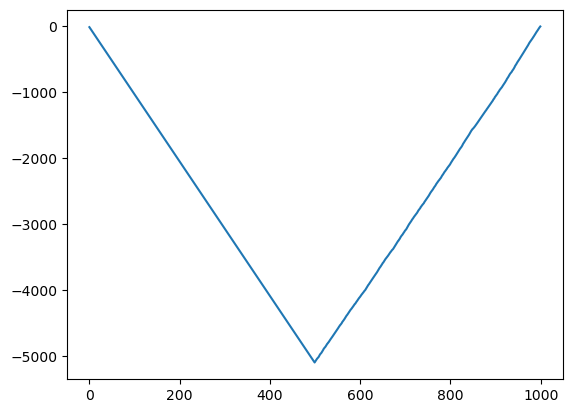

In [10]:
plt.plot(D_prime)

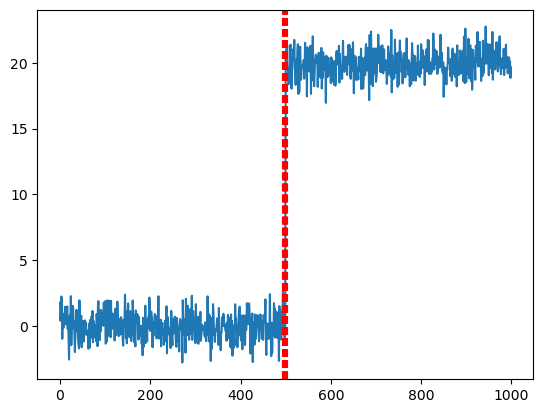

In [11]:
plt.plot(X)
for val in ol_lst:
    plt.axvline(val, color='r', linestyle='--')

In [52]:
info_wo_tle_df = pd.read_csv('Database/58400.csv', index_col=0)
name = 'perigee'
df = info_wo_tle_df[['year', 'month', 'day', 'hour', 'minute', name]]

In [56]:
info_wo_tle_df.columns

Index(['tle1', 'tle2', 'year', 'month', 'day', 'hour', 'minute', 'x', 'y', 'z',
       'vx', 'vy', 'vz', 'altitude', 'velocity', 'apogee', 'perigee',
       'inclination', 'eccentricity', 'raan'],
      dtype='object')

In [54]:
df_1 = df.copy()
df_1.loc[:, 'datetime'] = pd.to_datetime(df_1[['year', 'month', 'day', 'hour', 'minute']])
df_1.set_index('datetime', inplace=True)
df_1.drop(columns=['year', 'month', 'day', 'hour', 'minute'], inplace=True)
df_1 = df_1.resample('5min').mean()

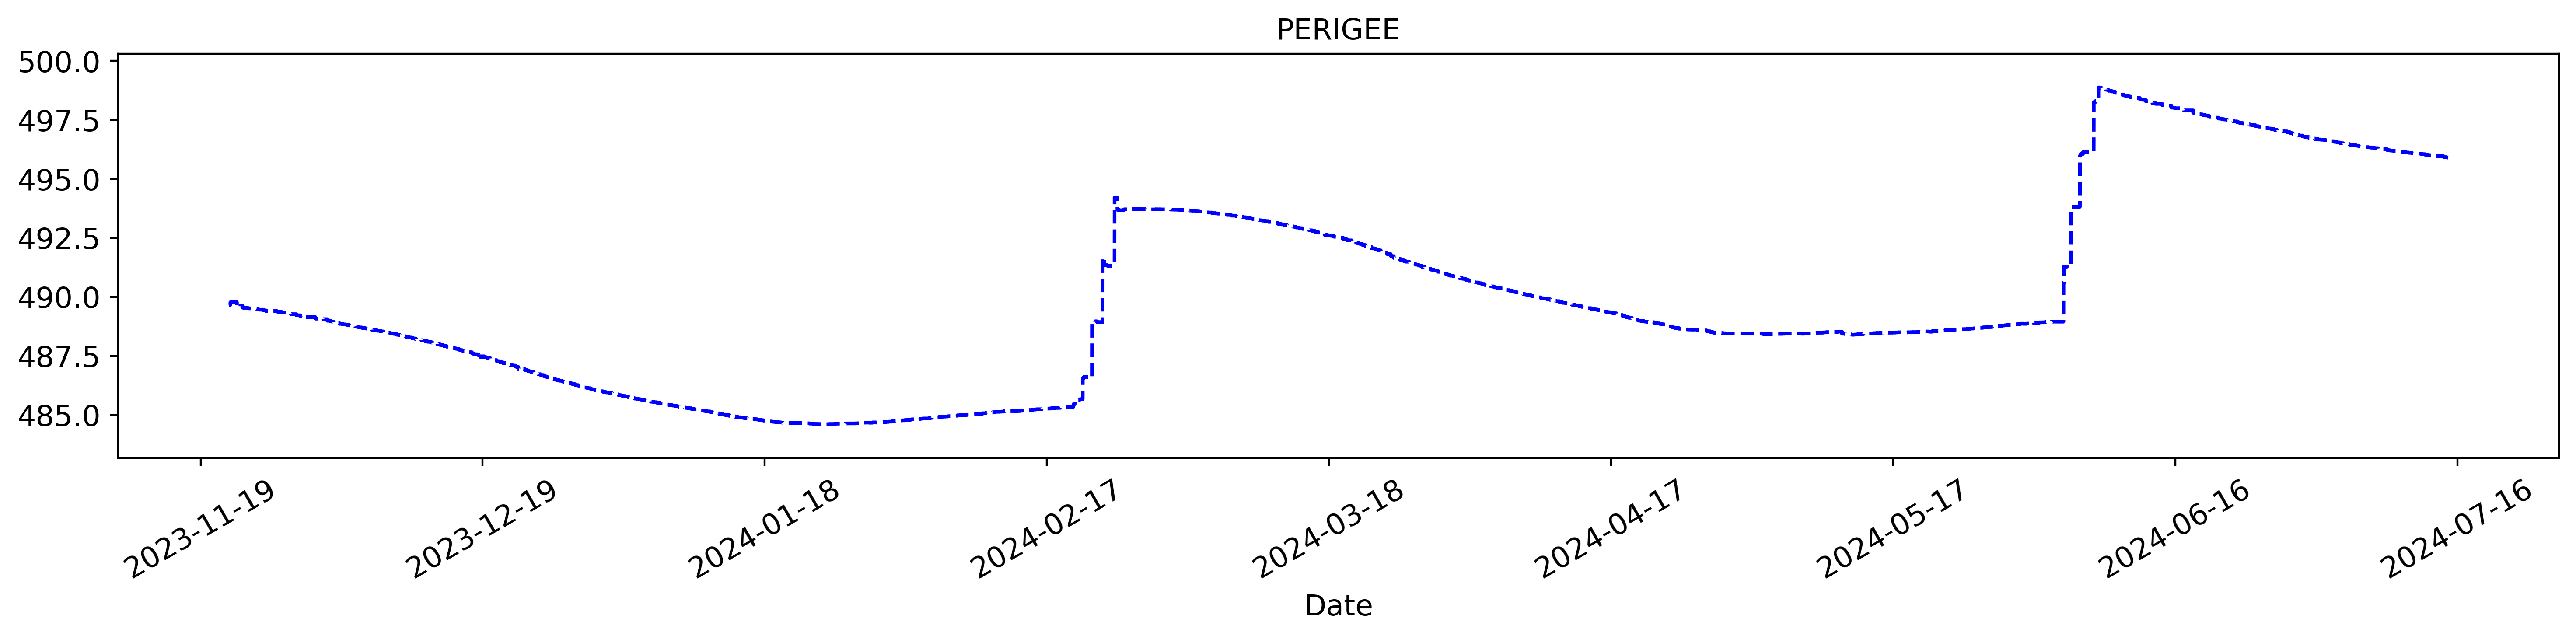

In [55]:
draw_graph(df_1, name.upper(), '',
           pd.DataFrame(df_1.iloc[[]].index.date).drop_duplicates().values.tolist(), 'blue')

In [14]:
# df_1 = df_1.rolling(window=120).mean().dropna()
df_2 = np.log(df_1).diff().dropna().values

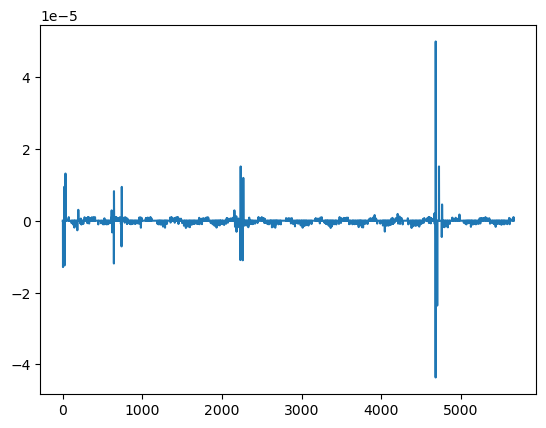

In [15]:
plt.plot(df_2)

In [16]:
# from statsmodels.tsa.stattools import kpss
# from statsmodels.tsa.stattools import adfuller
# 
# result = adfuller(df_2)
# print('ADF')
# print(f'Statistics: {result[0]}')
# print(f'p-value: {result[1]}')
# print(f'Critical values: {result[4]}')
# print('---' * 40)
# 
# result = kpss(df_2)
# print('KPSS')
# print(f'Statistics: {result[0]}')
# print(f'p-value: {result[1]}')
# print(f'Critical values: {result[3]}')
# print('---' * 40)

In [17]:
# 168, 336, 720
window_size = 168
lambda_lst = []
cv_lst = []
current_lst = []

for i in tqdm(range(window_size, len(df_2), 1)):
    X = df_2[i - window_size:i]
    T = len(X)
    m = round(T ** (1 / 4))

    # CUSUM 계산
    CUSUM = compute_CUSUM(X)

    # gamma 계산
    gamma = compute_gamma(X, T, m)

    # lambda_hat 계산
    lambda_hat = compute_lambda(gamma, m)
    lambda_lst.append(lambda_hat)
    # D_prime 계산

    D_prime = compute_D_prime(CUSUM, T, lambda_hat)

    critical_value = compute_percentile(D_prime, T, 95)
    cv_lst.append(critical_value)
    current_lst.append(np.abs(D_prime[-2]) * np.sqrt(T / 2))

100%|██████████| 5495/5495 [00:01<00:00, 4284.59it/s]


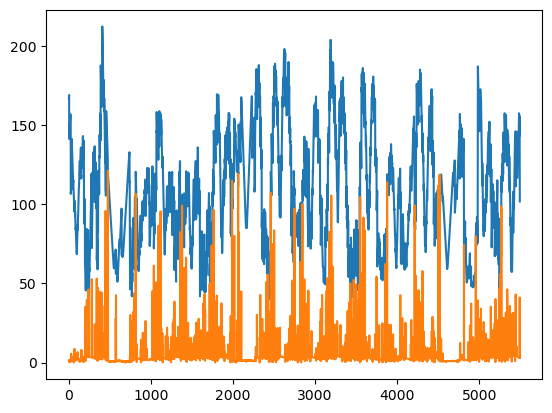

In [18]:
# plt.plot(lambda_lst)
plt.plot(cv_lst)
plt.plot(current_lst)

In [19]:
ol_lst = list(np.where((np.array(current_lst) > np.array(cv_lst)))[0] + window_size)

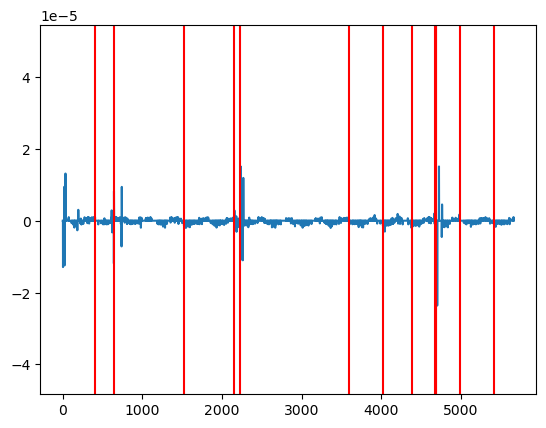

In [20]:
plt.plot(df_2)
for point in ol_lst:
    plt.axvline(point, color='r')

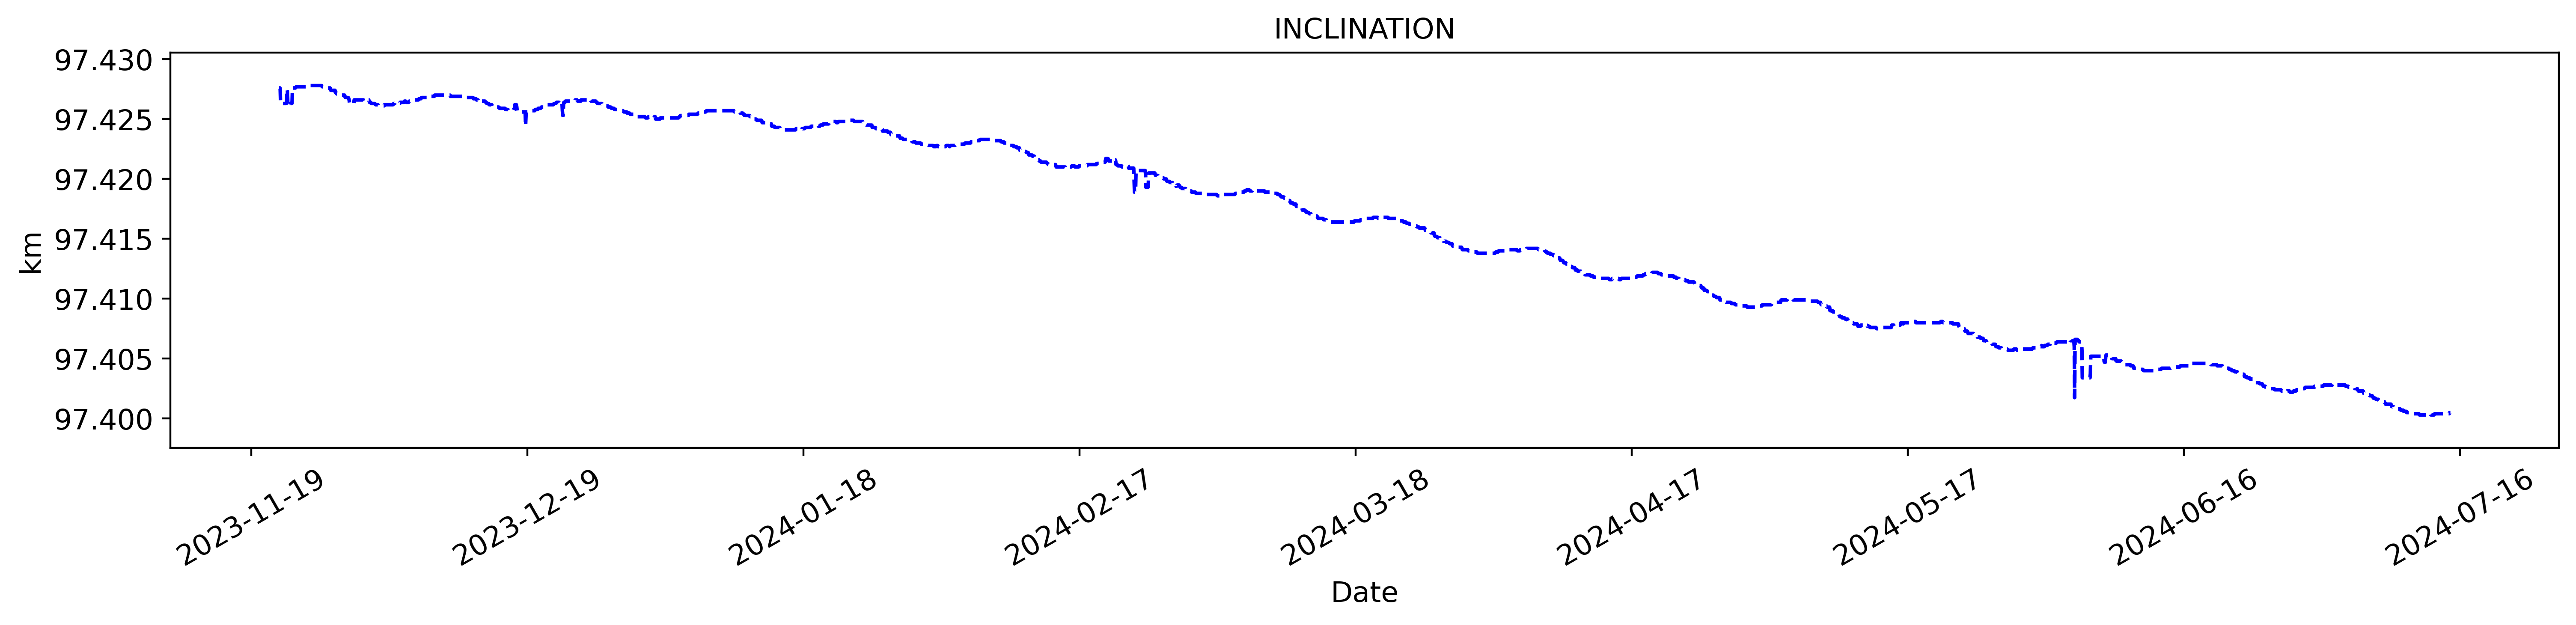

In [22]:
draw_graph(df_1, name.upper(), 'km',
           pd.DataFrame(df_1.iloc[[]].index.date).drop_duplicates().values.tolist(), 'blue')

In [203]:
from scipy.stats import rankdata, chi2
from scipy.stats import kruskal

def offline_KWtest(array, ol_lst, N):
    not_ol_lst = []
    for i in ol_lst:
        if i < N or i + N > len(array):
            continue
        data = array[i - N:i + N]
        unique_values, counts = np.unique(data, return_counts=True)

        average_ranks = rankdata(data, method='average')
        # ranks = np.argsort(unique_values)
        # rank_map = {val: rank for val, rank in zip(unique_values, ranks)}
        # average_ranks = np.array([rank_map[val[0]] for val in data])

        X1 = average_ranks[:N].sum() ** 2
        X2 = average_ranks[N:].sum() ** 2
        KW = (12 / (len(data) * (len(data) + 1))) * (X1 / N + X2 / N) - 3 * (len(data) + 1)
        ties_correction = 1 - (1 / ((len(data)) ** 3 - 2 * N)) * np.sum(counts ** 3 - counts)
        
        if ties_correction == 0:
            continue
            
        KW_star = KW / ties_correction

        alpha = 0.5
        p_value = 1 - chi2.cdf(KW_star, 1)
        if p_value >= alpha:
            not_ol_lst.append(i)

    return not_ol_lst

In [204]:
KW_ol_lst = [ol for ol in ol_lst if ol not in offline_KWtest(df_2, ol_lst, 10)]

In [205]:
len(ol_lst)

13

In [206]:
len(KW_ol_lst)

8

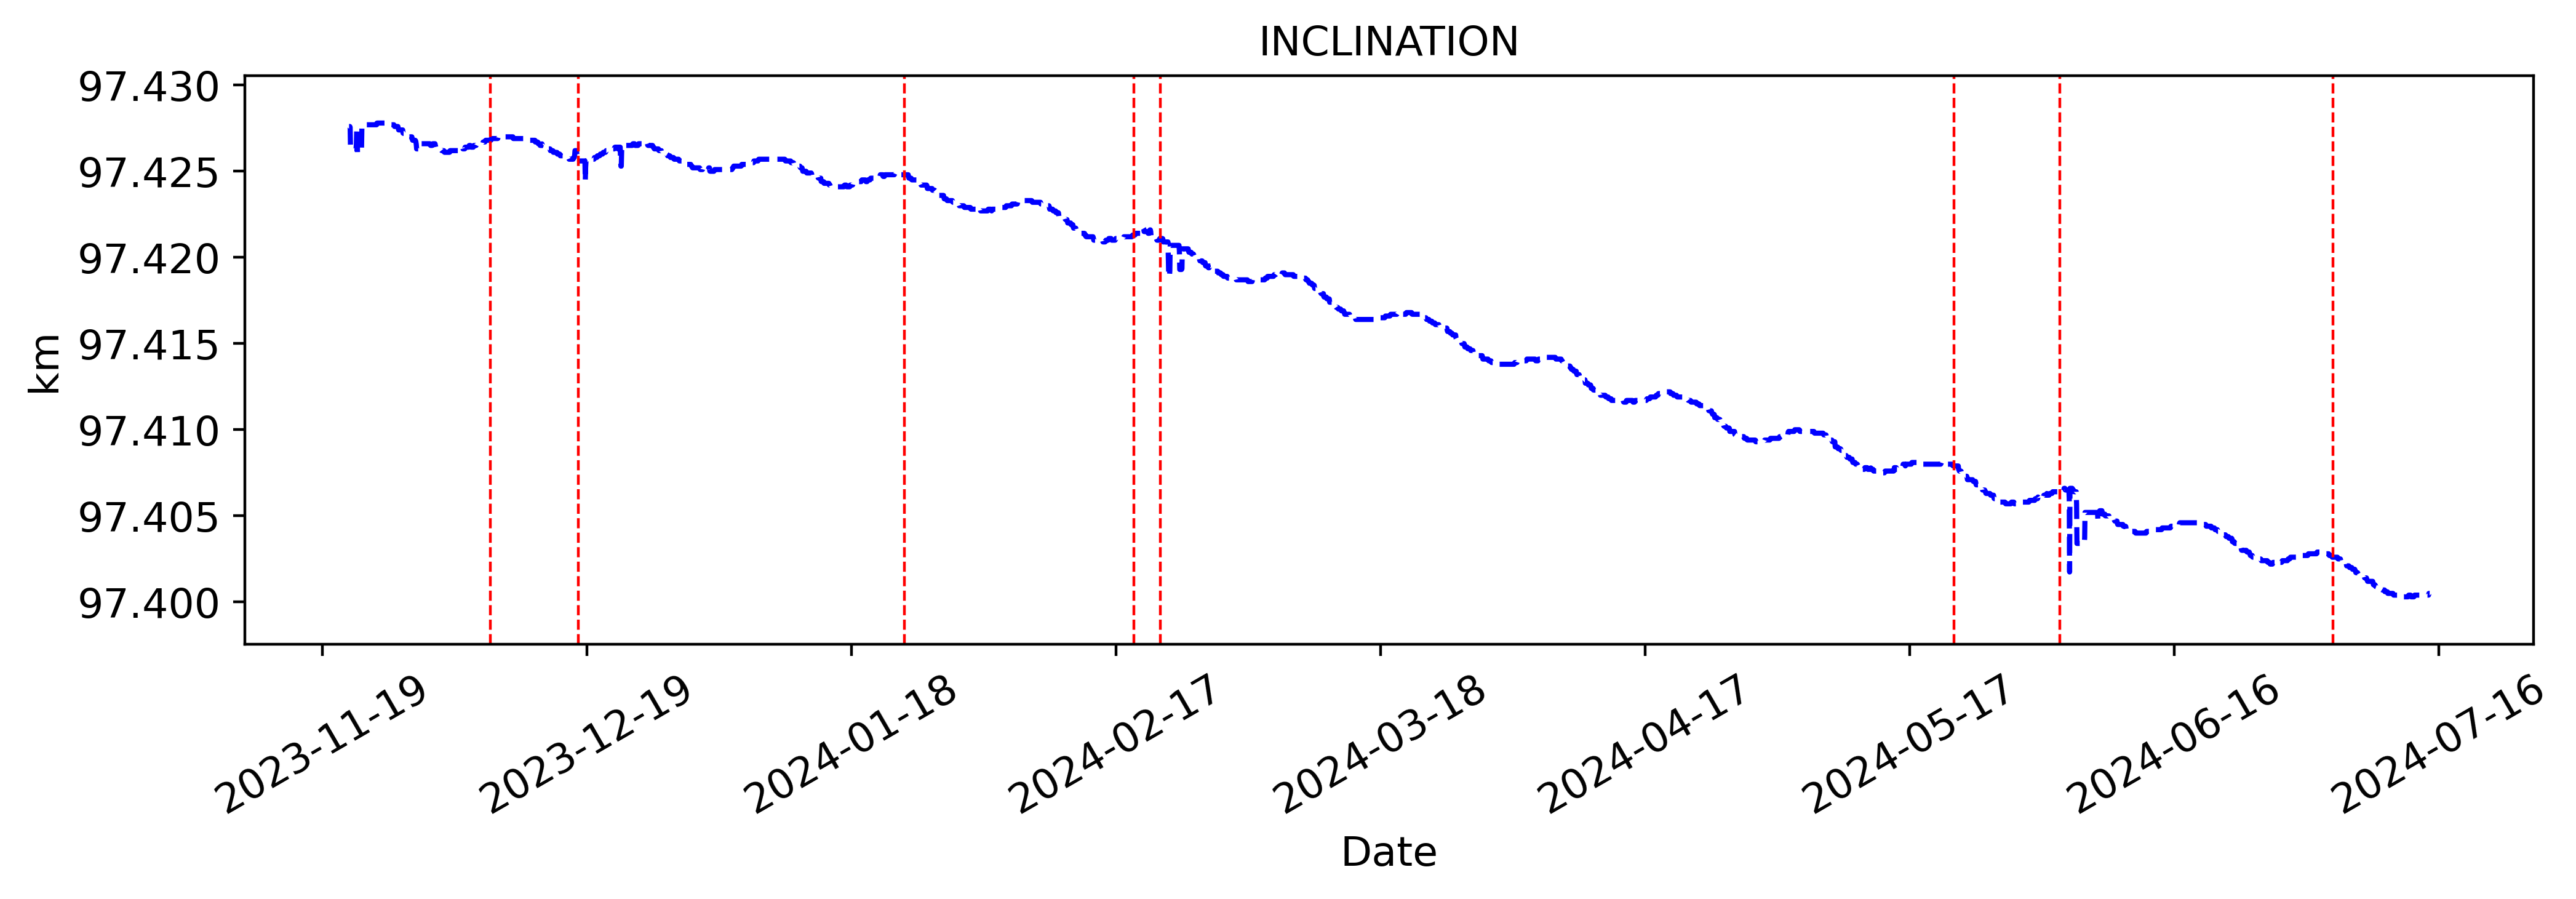

In [207]:
draw_graph(df_1, name.upper(), 'km',
           pd.DataFrame(df_1.iloc[KW_ol_lst].index.date).drop_duplicates().values.tolist(),
           'blue')